## Simple Monte Carlo

A posterior is already naturally factored into a likelihood function and a prior PDF.

## $$p(\theta|x) \propto p(x|\theta)\,p(\theta)$$

Applying this in the MC integration context leads to the Simple Monte Carlo algorithm:

```
while we want more samples
    draw theta from p(theta)
    compute weight = p(x|theta)
    store theta and weight
```

Obtaining marginal distribution(s) for $\theta$ then reduces to constructing weighted histograms of the samples.

SMC is indeed simple (as long as the prior is simple to draw from), but if the priors are not very informative then it still wastes many likelihood evaluations where the posterior is small. 

However, refinements of this approach lead to some more advanced algorithms. Once class of refinements is in how the samples are drawn:

### Rejection sampling
For this method, we need to define an *envelope function* which everywhere exceeds the target PDF, $p(x)$, and can be sampled. Let this be $Ag(x)$ where $A$ is a scaling factor and $g(x)$ is a PDF we know.

Then the algorithm is
```
while we want more samples
    draw a random value for x from some distribution g in the variable x
    draw u from Uniform(0,1)
    if u <= p(x)/(A*g(x)), keep the sample x
    otherwise, reject x
```

# Problem 1: Rejection Sampling

Implement a rejection sampler corresponding to the example figure above that illustrates the method. For this example,

* $p(x)$ is the $\chi^2$ distribution with 3 degrees of freedom

* $A=\pi$

* $g(x)$ is a normal distribution with mean 0 and standard deviation 5

Verify that your samples do indeed approximate the target PDF.

In [123]:
# YOUR CODE HERE
import numpy as np
from scipy.stats import chi2, norm
import matplotlib.pyplot as plt

# while we want more samples
#     draw a random value for x from some distribution g in the variable x
#     draw u from Uniform(0,1)
#     if u <= p(x)/(A*g(x)), keep the sample x
#     otherwise, reject x

df = 3
A = np.pi
n = 1000
x_accept = []
x_reject = []

while len(x_accept)<n:
    x = np.random.normal(loc=0.0, scale=1.0, size=None)
    u = np.random.uniform(0,1,size=None)
    p_x = chi2.pdf(x, df)
    #print(f'p_x: {p_x}')
    g_x = norm.pdf(x, loc=0.0, scale=5.0)
    #print(f'g_x: {g_x}')
    if u <= p_x/(A*g_x):
        x_accept.append(x)
    else:
        x_reject.append(x)

#x_accept

In [124]:
x_total = x_accept + x_reject
print('number of total samples', len(x_total))
print('Acceptance rate', len(x_accept)/len(x_total))

number of total samples 2400
Acceptance rate 0.4166666666666667


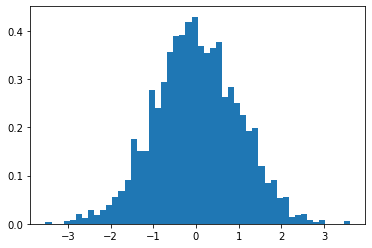

In [126]:
hist = plt.hist(x_total, bins=50, density=True)
plt.show()

In [127]:
pdf = chi2.pdf(x_total, df)
#pdf_norm = pdf/np.sum(pdf)
pdf_norm = pdf / np.linalg.norm(pdf, axis=-1)
pdf_norm

array([0.03135668, 0.03232767, 0.02462319, ..., 0.        , 0.        ,
       0.        ])

Text(0.5, 1.0, 'target pdf of total samples')

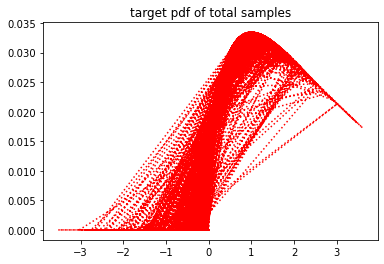

In [128]:
plt.plot(x_total, pdf_norm,color='r', ls=':')
plt.title("target pdf of total samples")

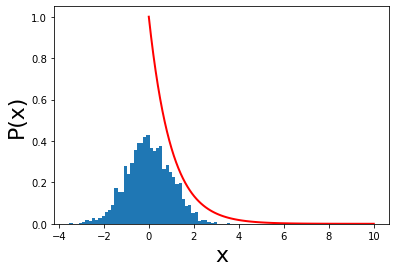

In [129]:
def inv_trans_demo(x, lam):
    hist = plt.hist(x, bins=50, density=True)
    xs = np.linspace(0.0, 10.0/lam, 100)
    pdf = lam * np.exp(-lam*xs)
    pdfline = plt.plot(xs, pdf, 'r', lw=2)
    plt.xlabel(r'x', fontsize=22)
    plt.ylabel(r'P(x)', fontsize=22);

inv_trans_demo(x_total, 1)

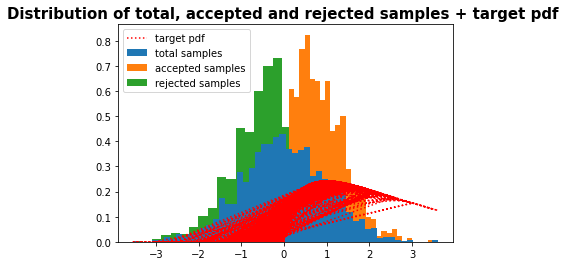

In [143]:
hist_total = plt.hist(x_total, bins=50, density=True, label='total samples', zorder=0)
hist_accept = plt.hist(x_accept, bins=30, density=True, label='accepted samples', zorder=-1)
hist_reject = plt.hist(x_reject, bins=30, density=True, label='rejected samples', zorder=-2)
plt.plot(x_total, pdf,color='r',ls=':', label='target pdf')
plt.title("Distribution of total, accepted and rejected samples + target pdf ",size=15,fontweight="bold")
plt.legend()

This technique is at the heart of a  very widely used (by scientists anyway) and simple to implement technique: the **Metropolis-Hastings** algorithm, which is one example of *Markov Chain Monte Carlo.*

### Markov Chains

A Markov Chain is a sequence where the $n$th entry depends explicitly on the $(n-1)$th, but not (explicitly) on previous steps. The chain will be a random walk through parameter space.


### Formalities of MCMC

Markov chains provide a powerful way to sample PDFs, provided that the transition kernel/proposal distribution - how we go from state 1 to state 2  satisfies a few requirements
* Detailed balance: any transition must be reversible; the probability of being at $x$ and moving to $y$ must equal the probability of being at $y$ and moving to $x$
* Ergodicity: the process may not be periodic, but it nevertheless must be possible to return to a given state in finite time
* It must be possible, in principle, to reach any state with non-zero prior probability

#### Why does it work?
The probability of an arbitrary point from such a chain being located at $x'$ is (marginalizing over the possible immediately preceding points)

## $$p(x') = \int dx \, p(x) \, T(x'|x)$$

where $T(x'|x)$ is the transition probability of a step from $x$ to $x'$.

If we have detailed balance, 

## $$p(x)T(x'|x) = p(x')T(x|x')$$

rearranging:

## $$ \frac{T(x'|x)}{T(x|x')} = \frac{p(x')}{p(x)} $$

The basic trick to connect this with rejection sampling is to break the transition into two steps:
1. A proposal, g(x'| x)
and 
2. Acceptance ratio, A(x'|x)

i.e. 

## $$ T(x'|x) = A(x'|x) g(x'| x) $$ 

rearranging again :

## $$ \frac{A(x'|x)}{A(x|x')} = \frac{p(x')g(x|x')}{p(x)g(x'|x) }$$


## Metropolis-Hastings
This algorithm can be thought of as an MCMC adaptation of rejection sampling. We need to define
1. An initial state (parameter values)
2. A proposal distribution, $g(x'|x)$, giving the probability that we attempt to move from $x$ to $x'$.

Let $P$ be the distribution we want to sample. The algorithm is then
```
set x to an initial state
compute p(x)
while we want more samples
    draw x' from the proposal distribution g(x'|x)
    compute p(x')
    draw u from Uniform(0,1)
    if u <= p(x')/p(x) * g(x|x')/g(x'|x), set the state x=x'
    otherwise, x stays the same
    store x as a sample
```

Compare this to the rejection sampling algorithm above!

Notice that the probability of accepting a step  (once it's proposed) is

## $$A(x',x) = \mathrm{min}\left[1, \frac{p(x')g(x|x')}{p(x)g(x'|x)}\right]$$

Let's look again at the requirement of detailed balance

> the probability of being at $x$ and moving to $y$ must equal the probability of being at $y$ and moving to $x$

The first of these is $p(x)g(x'|x)A(x',x)$, where

* $p(x)$ is the posterior density (probability of *being* at $x$, if we're sampling $P$ properly)

* $g(x'|x)$ is the proposal distribution (probability of attempting a move to $x'$ from $x$)

* $A(x',x)$ is the probability of accepting the proposed move

With this definition of $A$, detailed balance is automatically satisfied!

## $$p(x)g(x'|x)A(x',x) \equiv p(x')g(x|x')A(x,x')$$

Note that **even if a step is rejected, we still keep a sample** (the original state, without moving). The difficulty of finding a temptingly better point is important information!


### Metropolis
If the proposal distribution is translation invariant (i.e. only depends on the distance between the points), $g(x'|x)=g\left(\left|x'-x\right|\right)$, then it drops out of the *acceptance ratio* that decides whether to accept a step. 

**The most basic choice you can make is a Gaussian.**

For an N-dimensional Gaussian proposal function, $g$,  an *acceptance fraction* $A$ of $\sim25\%$ is optimal.

## $$A(x',x) = \mathrm{min}\left[1, \frac{p(x')}{p(x)}\right]$$

This is the original Metropolis algorithm, and is the easiest case to implement.

In this case, we *always* accept a jump to higher $p$, and *sometimes* accept one to lower $p$.

You'll have to tune the $\sigma$ of your Gaussian proposal function g by hand to make sure that your get a ~25% acceptance ratio. Note that this sigma is simply telling you the distribution of $x'$ from $x$.

# Problem 2: Metropolis


You guessed it... Implement the Metroplis Hastings algorithm in python.
Your implementation should accept an arbitary function as an argument (just as you've been passing to `scipy.optimize`)

Test it by sampling both the `circle` and `pgauss` function below 10,000 times and plotting your samples as you did in class (don't plot up your rejected). You can implement a prior function that imposes bounds. 

Look at your first 100 samples and then samples 500 to 600 for the `pgauss` case and comment on the difference. Think about this on Problem 3!

In [154]:
# YOUR CODE HERE
import scipy.stats as st

def circle(x, y):
    return (x-1)**2 + (y-2)**2 - 3**2

mus = np.array([5, 5])
sigmas = np.array([[1, .9], [.9, 1]])

def pgauss(x, y):
    return st.multivariate_normal.pdf([x, y], mean=mus, cov=sigmas)

In [149]:
def my_metropolis_hastings(p, x0, sigma, *args, nsamp=10000):
    ndim = 2
    x = np.array(x0)
    samples = np.zeros((nsamp, ndim))# we need something to save the samples we want  
    sigma = np.array(sigma)
    #p_x = p(x[0], x[1])
    
    for i in range(nsamp):# while we want more samples

        x_prime = x + sigma*np.random.randn(ndim)

        if np.random.rand() < (p(*x_prime, *args) / p(*x, *args)):
            x = x_prime
            
        samples[i] = x # we save the sample to the chain
    return samples


#Metropolis Hastings
def mh_demo(p, x0, sigma, nsamp=10000):
    samples = metropolis_hastings(p, x0, sigma, nsamp=nsamp)

    
    # create some axes
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    ax0, ax1, ax2 = axs
    
    # plot all the data in grey
    ax0.scatter(samples[:, 0], samples[:, 1], color='grey', alpha=0.1, marker='.')
    ax1.plot(samples[:, 0], marker='.', color='blue', alpha=0.1, ls='-')
    ax2.plot(samples[:, 1], marker='.', color='red', alpha=0.1, ls='-')
    return fig

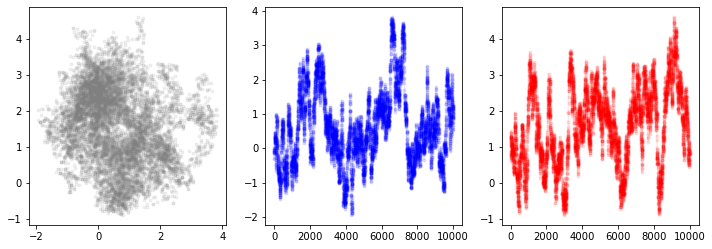

In [152]:
mh_demo(circle, np.array((0,1)), sigma=np.array((1e-1,1e-1)))
plt.show()

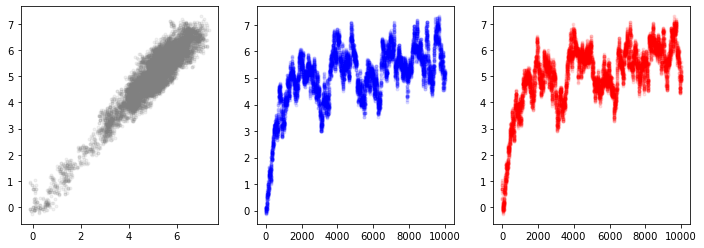

In [155]:
mh_demo(pgauss, np.array((0,1)), sigma=np.array((1e-1,1e-1)))
plt.show()

#### Look at your first 100 samples and then samples 500 to 600 for the pgauss case and comment on the difference. Think about this on Problem 3!

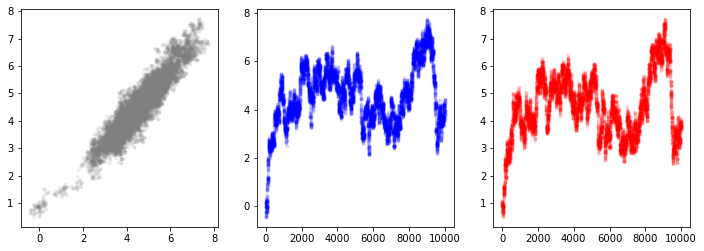

In [156]:
#Metropolis Hastings
def mh_demo_100(p, x0, sigma, nsamp=10000):
    samples = metropolis_hastings(p, x0, sigma, nsamp=nsamp)
    samples100 = samples[:100]
    
    # create some axes
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    ax0, ax1, ax2 = axs
    
    # plot all the data in grey
    ax0.scatter(samples[:, 0], samples[:, 1], color='grey', alpha=0.1, marker='.')
    ax1.plot(samples[:, 0], marker='.', color='blue', alpha=0.1, ls='-')
    ax2.plot(samples[:, 1], marker='.', color='red', alpha=0.1, ls='-')
    return fig

mh_demo_100(pgauss, np.array((0,1)), sigma=np.array((1e-1,1e-1)))
plt.show()

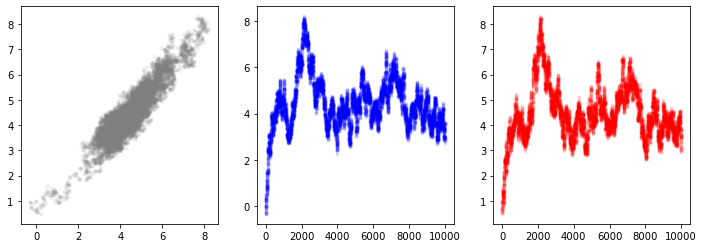

In [157]:
#Metropolis Hastings
def mh_demo_500(p, x0, sigma, nsamp=10000):
    samples = metropolis_hastings(p, x0, sigma, nsamp=nsamp)
    samples100 = samples[500:601]
    
    # create some axes
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    ax0, ax1, ax2 = axs
    
    # plot all the data in grey
    ax0.scatter(samples[:, 0], samples[:, 1], color='grey', alpha=0.1, marker='.')
    ax1.plot(samples[:, 0], marker='.', color='blue', alpha=0.1, ls='-')
    ax2.plot(samples[:, 1], marker='.', color='red', alpha=0.1, ls='-')
    return fig

mh_demo_500(pgauss, np.array((0,1)), sigma=np.array((1e-1,1e-1)))
plt.show()

Looks like samples from 0-100 and 500-600 are in opposite?!!

In [ ]:
size=16,fontweight="bold"

## Next HW: Using your sampler for a real problem where a grid would have been really painful.

# Q3 (Extra Credit: 1 point): Did you fill out the survey? (https://forms.gle/PGnsErRmagdBmrKX9)

In [144]:
# Yes I did